Class,

We now embark on a simple text-sentiment classification exercise using a host of methods/algorithms such as Naiva Bayes, SVM, Logistic regression, Random forests and boosted regressions the details of which you'll cover in later courses.

Aim of this exercise is to demo the use of std libraries to do supervised classification exercises on labeled text data.

See below

## Importing the required libraries

We'll use select components from the comprehensive *sklearn* library. Some select components of interest are:

**model_selection** : for splitting the data into train and test dataset 

**preprocessing**: for encoding the label so that it can be used in the machine learning model

**linear_model**: to implement linear models like linear regresson, logistic regression etc

**naive_bayes**: for the class of Naive Bayes models

**metrics**: For calculating the model metrics such as accuracy.

**svm**: For implementing SVM or *Support Vector Machine* models. 

**TfidfVectorizer**: for calculating DTM under TD-IDF conditions

**CountVectorizer**: for implementing DTM under TF

**ensemble**: To implement Ensemble models like *Random Forests* 

**pandas**: For Dataframes

If you're using the Anaconda py distribution, much of sklearn comes prepackaged. Else, might take some time to import. 

E.g., to import *xgboost*, type on command line: *$ pip install xgboost*

In [3]:
## setup chunk
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from sklearn.metrics import classification_report
import pandas, xgboost, numpy, textblob, string  # $ pip install textblob
import csv,re,nltk
import time
import pandas as pd
from sklearn.metrics import roc_curve,auc

import matplotlib.pyplot as plt
import numpy as np

In [0]:

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [0]:
# # build panda DF to house the data
# trainDF = pd.read_csv('imdb.csv')
# # trainDF['text'] = texts
# # trainDF['label'] = labels
# trainDF.iloc[:8,]  # view a few records
 

In [4]:
# working very fast compare to upload
trainDF = pd.read_csv('https://raw.githubusercontent.com/yogesh1612/mlbm-datasets/master/imdb.csv')


<Figure size 576x432 with 0 Axes>

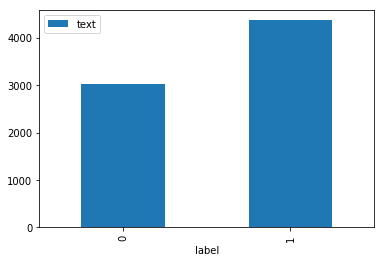

In [5]:
# Distribution of star ratiings
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
trainDF.groupby('label').count().plot.bar(ylim=0)
plt.show()

## Split Dataset into Train & Test to Assess Model Accuracy

Part of std operating proc in training machines on labeled data is (randomly) splitting the data into two parts - 

1] a *Training* or Calibration dataset on which the machine searches for the best function connecting labeled outcomes to data features

2] a *Test* or Validation dataset on which the trained model is run to assess the accuracy of the model's predicted outcomes against known outcomes.

We'll use sklearn's *model_selection.train_test_split()* func for the above. 

Then, in preprocessing we use a label *encoder* to setup the LHS, via func *preprocessing.LabelEncoder().fit_transform()*.

See below.

In [6]:
# split the DF into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

# label encode the target variable into 0/1
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

## Creating a DTM of the dataset 

Recall we'd built DTMs in R's tidytext with the cast_dtm() func. Now we see sklearn's approach to doing the same using the *CountVectorizer()* func. 

P.S. You can read more about the func's arguments and attributes [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).


In [7]:
# create a count vectorizer TF-DTM object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
t1 = time.time()
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)
t2 = time.time()

print(t2 - t1, "secs")  # ~ 0.15 secs to create DTM. Not bad, eh?
xtrain_count.shape
xvalid_count.shape

2.6850361824035645 secs


(1848, 45851)

## Creating TFIDF on the word level for the dataset 

Recall TFIDF wale DTMs from the previous classes? We'd said that its hard to say a priori which might be more relevant or better-performing in any situ and that we should try both and see? 

Now, in this text classifn exercise, would it make more sense to use TF or an IDF wala DTM? Why not try both and see?

Below, we use sklearn's *TfidfVectorizer()* func to build an IDF wala DTM.

Behold.

In [8]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
t1 = time.time()
tfidf_vect = tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)
t2 = time.time()

print(t2 - t1, "secs")  # ~ 2.43 secs again
xtrain_tfidf.shape  # but many more tokens thsi time!

2.631000280380249 secs


(5542, 5000)

## Function to train the model 

The arguments of the user defined func *train_model()* below allow you to:

1] pick a classifier algorithm or method to run (P.S. see [here](https://scikit-learn.org/stable/supervised_learning.html) for a list)

2] input the feature set and the labels

3] both for training and validation datasets.

Am setting *is_neural_net=False* as that is worth a whole other course some other time.

See below.

In [9]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    #print(len(predictions))
    predDF = pandas.DataFrame()
    predDF['text'] = valid_x
    predDF['actual_label'] = valid_y
    predDF['model_label'] = predictions


    fpr, tpr, thresholds = roc_curve(valid_y, predictions)
    accuracy = metrics.accuracy_score(predictions, valid_y)



    # print(predDF.iloc[:8,])
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return list([accuracy,fpr, tpr, thresholds])

## Naive Bayes Model using DTM and TFIDF

Now rubber meets road. Let's use the *train_model* func above starting simple with Naive Bayes. 

Note how we output both actual and predicted label for each case to facilitate comparison.

See below.


Naive Bayes on DTM accuracy: 0.8365800865800865

Naive Bayes on WordLevel TF-IDF accuracy: 0.8436147186147186
0.06200861930847168 secs for NB on TF


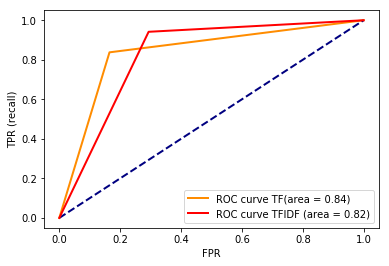

In [10]:
# Naive Bayes on DTM
# scores=list()
t1 = time.time()
scores_nb_dtm = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
lw = 2
fpr_nb_dtm = scores_nb_dtm[1]
tpr_nb_dtm = scores_nb_dtm[2]
roc_auc_nb_dtm = auc(fpr_nb_dtm, tpr_nb_dtm)
plt.plot(fpr_nb_dtm, tpr_nb_dtm,color="darkorange",lw=lw,label='ROC curve TF(area = %0.2f)' % roc_auc_nb_dtm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

t2 = time.time()
print("\nNaive Bayes on DTM accuracy: "+ str(scores_nb_dtm[0]))

# Naive Bayes on Word Level TF IDF Vectors
scores_nb_tfidf = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
fpr_nb_tfidf = scores_nb_tfidf[1]
tpr_nb_tfidf = scores_nb_tfidf[2]
roc_auc_nb_tfidf = auc(fpr_nb_tfidf, tpr_nb_tfidf)
plt.plot(fpr_nb_tfidf, tpr_nb_tfidf,color="red",lw=lw,label='ROC curve TFIDF (area = %0.2f)' % roc_auc_nb_tfidf)
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
print("\nNaive Bayes on WordLevel TF-IDF accuracy: "+ str(scores_nb_tfidf[0]))

print(t2-t1, "secs for NB on TF")  # 0.01 secs. Fast!

# 

## Linear Classifier using DTM and TFIDF

Same as above, we try logistic regression as our classification method this time.

P.S. I'll expect more time here than in Naive Bayes which asumes conditional independence across cases.

See below.


Logistic Regression on DTM Accuracy: 0.8625541125541125

Logistic Regression on WordLevel TF-IDF: 0.8566017316017316
0.46801209449768066 secs for Logistic


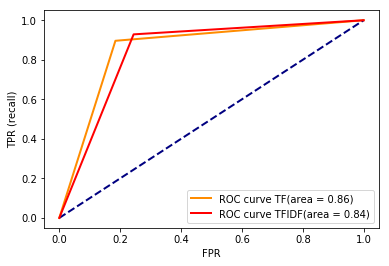

In [11]:
# Linear Classifier on DTM
scores_lr_dtm = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_count, train_y, xvalid_count)
print("\nLogistic Regression on DTM Accuracy: "+ str(scores_lr_dtm[0]))

lw = 2
fpr_lr_dtm = scores_lr_dtm[1]
tpr_lr_dtm = scores_lr_dtm[2]
roc_auc_lr_dtm = auc(fpr_lr_dtm, tpr_lr_dtm)
plt.plot(fpr_lr_dtm, tpr_lr_dtm,color="darkorange",lw=lw,label='ROC curve TF(area = %0.2f)'% roc_auc_lr_dtm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')


# Linear Classifier on Word Level TF IDF Vectors
t1 = time.time()
scores_lr_tfidf = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf, train_y, xvalid_tfidf)

fpr_lr_tfidf = scores_lr_tfidf[1]
tpr_lr_tfidf = scores_lr_tfidf[2]
roc_auc_lr_tfidf = auc(fpr_lr_tfidf, tpr_lr_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf,color="red",lw=lw,label='ROC curve TFIDF(area = %0.2f)'% roc_auc_lr_tfidf)
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
t2 = time.time()
print("\nLogistic Regression on WordLevel TF-IDF: "+ str(scores_lr_tfidf[0]))

print(t2-t1, "secs for Logistic")  # 0.02 secs

## SVM using DTM and TFIDF

SVM is a more complex method than the previous two and I'll assume more time here for that reason. 

SVM tries to find a line or plane or hyperplane in high-dimensions (the so-called support-vector) that best seperates one class of labels from another. Again, details in later courses.


SVM on DTM Model Accuracy: 0.8116883116883117

SVM on TFIDF Accuracy: 0.8625541125541125
39.952000856399536 secs in SVM


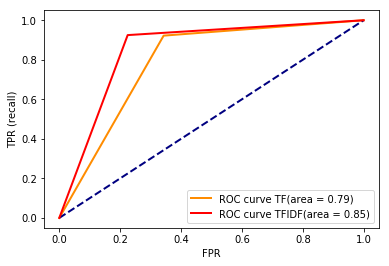

In [12]:
#SVM on DTM
t1 = time.time()
scores_svm_dtm = train_model(svm.SVC(), xtrain_count, train_y, xvalid_count)
lw = 2
fpr_svm_dtm = scores_svm_dtm[1]
tpr_svm_dtm = scores_svm_dtm[2]
roc_auc_svm_dtm = auc(fpr_svm_dtm, tpr_svm_dtm)
plt.plot(fpr_svm_dtm, tpr_svm_dtm,color="darkorange",lw=lw,label='ROC curve TF(area = %0.2f)'% roc_auc_svm_dtm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

t2 = time.time()
print("\nSVM on DTM Model Accuracy: "+str(scores_svm_dtm[0]))


# SVM on Ngram Level TF IDF Vectors
scores_svm_tfidf = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)

fpr_svm_tfidf = scores_svm_tfidf[1]
tpr_svm_tfidf = scores_svm_tfidf[2]
roc_auc_svm_tfidf = auc(fpr_svm_tfidf, tpr_svm_tfidf)
plt.plot(fpr_svm_tfidf, tpr_svm_tfidf,color="red",lw=lw,label='ROC curve TFIDF(area = %0.2f)'% roc_auc_svm_tfidf)
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

print("\nSVM on TFIDF Accuracy: "+str(scores_svm_tfidf[0]))

print(t2-t1, "secs in SVM")

Aha. Above we note that DTMs under TF and TFIDF weighing schemes actually produced dramatically different accuracy results under SVM.

The simpler, smaller feature set under TF performed way better. 

## Random Forest using DTM and TFIDF

Now we use a so-called *ensemble* method, i.e. a algorithm that runs a collection of classification tasks and averages or combines them to yield a final output. Often considered advantageous over one-shot methods in complex tasks.

A random forest, as the name implies, is an ensemble of decision trees. The random forest is actually a forest of decision trees grown from different starting points using different feature subsets and later combined to  gove an overall picture.

See below.


Random Forest on DTM Accuracy:  0.8008658008658008

Random Forest on WordLevel TF-IDF Accuracy:  0.8198051948051948
7.553041458129883 secs under RF


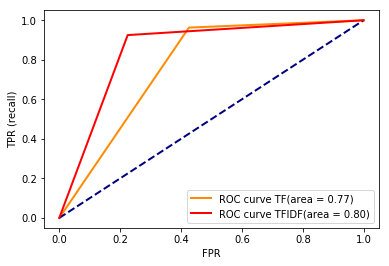

In [13]:
# RF on Count Vectors
scores_rf_dtm = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("\nRandom Forest on DTM Accuracy: ", scores_rf_dtm[0])
lw = 2
fpr_rf_dtm = scores_rf_dtm[1]
tpr_rf_dtm = scores_rf_dtm[2]
roc_auc_rf_dtm = auc(fpr_rf_dtm, tpr_rf_dtm)
plt.plot(fpr_rf_dtm, tpr_rf_dtm,color="darkorange",lw=lw,label='ROC curve TF(area = %0.2f)'% roc_auc_rf_dtm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# RF on Word Level TF IDF Vectors
t1 = time.time()
scores_rf_tfidf = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
fpr_rf_tfidf = scores_rf_tfidf[1]
tpr_rf_tfidf = scores_rf_tfidf[2]
roc_auc_rf_tfidf = auc(fpr_rf_tfidf, tpr_rf_tfidf)
plt.plot(fpr_svm_tfidf, tpr_svm_tfidf,color="red",lw=lw,label='ROC curve TFIDF(area = %0.2f)'% roc_auc_rf_tfidf)
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
t2 = time.time()
print("\nRandom Forest on WordLevel TF-IDF Accuracy: ", scores_rf_tfidf[0])

print(t2-t1, "secs under RF")

## Gradient Boosting using DTM and TFIDF

Finally, our last classifn method for the day - gradient boosting that follows 'boosting' principles. IOW, it focusses on misclassified cases and assigns more weight to learning from misclassified cases.


XGBoost on DTM Accuracy:  0.7949134199134199

XGBoost on DTM Accuracy WordLevel TF-IDF:  0.801948051948052
19.558059692382812 secs under xgboost


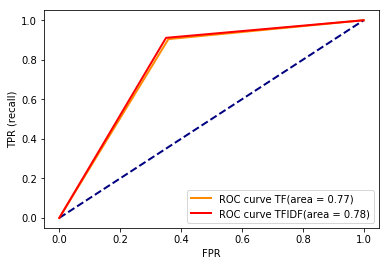

In [14]:
# Extereme Gradient Boosting on Count Vectors
t1 = time.time()
scores_xg_dtm = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
fpr_xg_dtm = scores_xg_dtm[1]
tpr_xg_dtm = scores_xg_dtm[2]
roc_auc_xg_dtm = auc(fpr_xg_dtm, tpr_xg_dtm)
plt.plot(fpr_xg_dtm, tpr_xg_dtm,color="darkorange",lw=lw,label='ROC curve TF(area = %0.2f)'% roc_auc_xg_dtm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

t2 = time.time()
print("\nXGBoost on DTM Accuracy: ", scores_xg_dtm[0])

# Extereme Gradient Boosting on Word Level TF IDF Vectors
scores_xg_tfidf = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
fpr_xg_tfidf = scores_xg_tfidf[1]
tpr_xg_tfidf = scores_xg_tfidf[2]
roc_auc_xg_tfidf = auc(fpr_xg_tfidf, tpr_xg_tfidf)
plt.plot(fpr_xg_tfidf, tpr_xg_tfidf,color="red",lw=lw,label='ROC curve TFIDF(area = %0.2f)'% roc_auc_xg_tfidf)
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
print("\nXGBoost on DTM Accuracy WordLevel TF-IDF: ", scores_xg_tfidf[0])

print(t2-t1, "secs under xgboost")

#### Compare all algos on DTM & TF-IDF respectively


Text(0,0.5,'TPR (recall)')

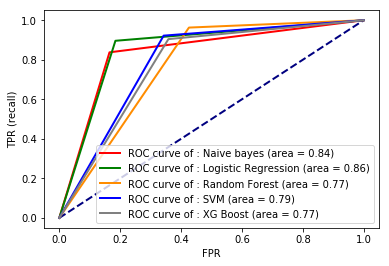

In [15]:
# DTM
# Plot all ROC curves
all_fpr = [fpr_nb_dtm,fpr_lr_dtm,fpr_rf_dtm,fpr_svm_dtm,fpr_xg_dtm]
all_tpr = [tpr_nb_dtm,tpr_lr_dtm,tpr_rf_dtm,tpr_svm_dtm,tpr_xg_dtm]
all_roc = [roc_auc_nb_dtm,roc_auc_lr_dtm,roc_auc_rf_dtm,roc_auc_svm_dtm,roc_auc_xg_dtm]
model = ['Naive bayes','Logistic Regression','Random Forest','SVM','XG Boost']
colour = ['red','green','darkorange','blue','gray']

plt.figure()

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

for (fpr, tpr, roc,model,color) in zip(all_fpr, all_tpr, all_roc,model,colour):
  plt.plot(fpr, tpr,color=color,lw=2,label='ROC curve of : %s (area = %0.2f)'% (model,roc))
plt.legend(loc=0)
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

#### Similarly, we can check for the TFIDF


Text(0,0.5,'TPR (recall)')

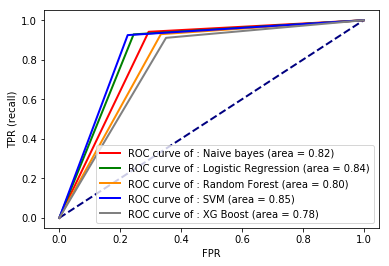

In [16]:
# TFIDF
# Plot all ROC curves
all_fpr = [fpr_nb_tfidf,fpr_lr_tfidf,fpr_rf_tfidf,fpr_svm_tfidf,fpr_xg_tfidf]
all_tpr = [tpr_nb_tfidf,tpr_lr_tfidf,tpr_rf_tfidf,tpr_svm_tfidf,tpr_xg_tfidf]
all_roc = [roc_auc_nb_tfidf,roc_auc_lr_tfidf,roc_auc_rf_tfidf,roc_auc_svm_tfidf,roc_auc_xg_tfidf]
model = ['Naive bayes','Logistic Regression','Random Forest','SVM','XG Boost']
colour = ['red','green','darkorange','blue','gray']

plt.figure()

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

for (fpr, tpr, roc,model,color) in zip(all_fpr, all_tpr, all_roc,model,colour):
  plt.plot(fpr, tpr,color=color,lw=2,label='ROC curve of : %s (area = %0.2f)'% (model,roc))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Well, so far so good. What Qs come to your mind?

What do you think? Which method performed *best*? Which DTM weighing scheme seems superior for this application? 

Can we use these methods if the number of classes exceeds 2? Etc.

Sudhir

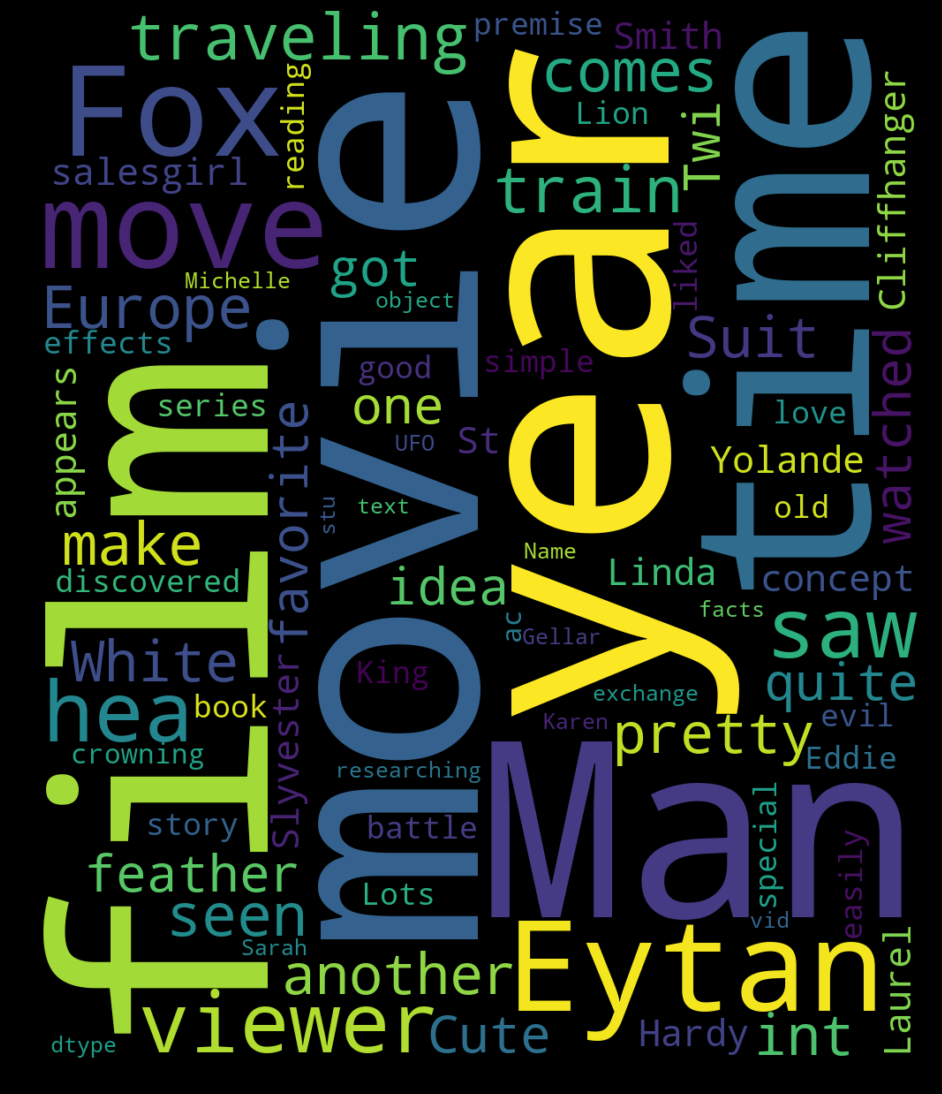

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = trainDF[trainDF.label==1].text
text = text[1:20]
wordcloud = WordCloud(
    width = 1000,
    height = 1200,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()